# Oliver Baby Sleep Data

This notebook explores a data set of baby sleep, feeding, diaper changes, and other avaialbe variables as provided by the App "Baby Daybook" which my wife and I used as our primary tracker, when our son was born.

In [3]:
import numpy as np            # The usual libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; #seaborn.set()

import sqlite3 as sql         # Need this since app data export is in .db format
#import datetime as dt
#import base64
#from datetime import date
#from IPython import display
#from base64 import b64decode
#import matplotlib as mpl

### First Explore the SQL Database (using sqlite)

In [4]:
# Connect to the database and create cursor to execute SQL statements and fetch query results

conn = sql.connect("BabyDaybook_20240306.db")
cursor = conn.cursor()

In [5]:
# Explore the database and its tables

sql_query1 = """SELECT name FROM sqlite_master 
    WHERE type='table';"""

#tables=cursor.execute(sql_query1)
tables=cursor.execute(sql_query1).fetchall()

print("\nTables in databse:\n")
print(tables)
print(type(tables))
print(type(tables[0]))


Tables in databse:

[('babies',), ('da_types',), ('daily_actions',), ('groups',), ('growth',), ('moments',), ('daily_notes',), ('reminders',), ('teething',)]
<class 'list'>
<class 'tuple'>


In [6]:
# Now let's see what parameteres are stored in the table columns

tableOfInterest =''.join(tables[2])              #converts tuple to string, choose index for given table of intereste 
print("Table of Interest:",tableOfInterest)

sql_query2 ="SELECT * FROM "+ tableOfInterest;

data=cursor.execute(sql_query2)

print("\nParameters in table:\n")
for column in data.description:
    print(column[0],end=',')
#print(type(data.description))

Table of Interest: daily_actions

Parameters in table:

uid,svt,updated_millis,user_uid,baby_uid,type,start_millis,notes,group_uid,end_millis,pause_millis,duration,left_duration,right_duration,in_progress,side,pee,poo,hair_wash,temperature,volume,amount,amount_unit,reaction,

In [90]:
# Afer going through the tables, daily_actions (index 2) has the data of interest 

tableOfInterest =''.join(tables[2])  
print("Table of Interest:",tableOfInterest)

sql_query3 = "SELECT type, start_millis, end_millis, duration, pee, poo, volume, notes FROM daily_actions"
#sql_query4 = "SELECT start_millis, end_millis, duration FROM daily_actions WHERE type = 'sleeping' "

data=cursor.execute(sql_query3).fetchall() #fetchone()

print("\nFirst 4 entries:\n")

for i in range (0,4):
    print(data.pop(i))

Table of Interest: daily_actions

First 4 entries:

('sleeping', 1644556680000, 1644570600000, 13920000, 0, 0, 0.0, '')
('bottle', 1644570900000, 0, 0, 0, 0, 74.0, '')
('sleeping', 1644573600000, 1644582900000, 9300000, 0, 0, 0.0, '')
('pump', 1644583800000, 0, 0, 0, 0, 110.0, '15min')


### Explore the SQL Database (using pandas)

Index(['uid', 'svt', 'updated_millis', 'user_uid', 'name', 'gender',
       'birthday', 'is_premature', 'expected_birthday', 'ui_color',
       'da_types_config', 'photo_base64', 'convert_units'],
      dtype='object')
Stored DOB: 1643097600000
Converted DOB: 2022-01-25 08:00:00
Picture data type: <class 'str'>


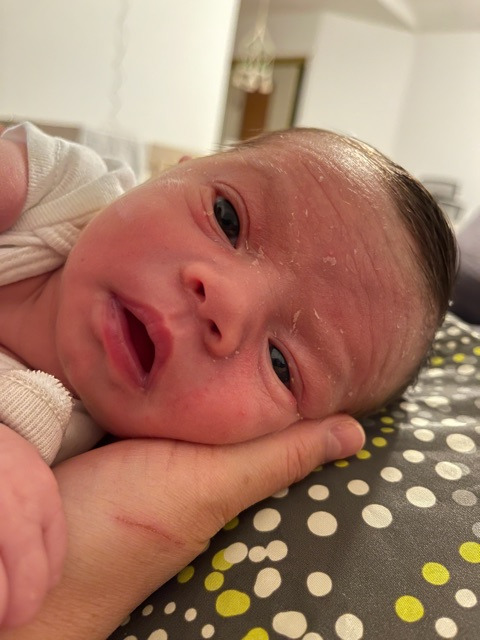

In [644]:
# More database exploration, but much simpler way to just import sql into pandas!!

babyInfo=pd.read_sql(sql_query2, conn)
print(babyInfo.columns)

babyName=babyInfo['name'][0]
babydob=babyInfo['birthday'][0]
print('Stored DOB:',babydob)
babydob=pd.to_datetime(babydob,unit='ms')
print('Converted DOB:',babydob)

babyPic=babyInfo['photo_base64'][0]
print('Picture data type:', type(babyPic))

with open("babyPic.png", "wb") as fh:
  fh.write(base64.urlsafe_b64decode(babyPic))

display.Image(b64decode(babyPic))

## Good practice for another time: put the corrected DOB datetime back into the database

In [653]:
# Let's get into the data of intersest (Sleep/Diaper/Feeding logs)

sql_query3 = "SELECT * FROM daily_actions"
Babydata=pd.read_sql(sql_query3, conn) # Dataframe object
type_counts = Babydata['type'].value_counts()

print('Size of Babydata:', Babydata.shape)
print('\nColumns of Babydata:\n', Babydata.columns)
print('\nTypes of logs:\n',Babydata['type'].unique())
print('\nEvent counts:\n')
print(type_counts)

Size of Babydata: (3515, 24)

Columns of Babydata:
 Index(['uid', 'svt', 'updated_millis', 'user_uid', 'baby_uid', 'type',
       'start_millis', 'notes', 'group_uid', 'end_millis', 'pause_millis',
       'duration', 'left_duration', 'right_duration', 'in_progress', 'side',
       'pee', 'poo', 'hair_wash', 'temperature', 'volume', 'amount',
       'amount_unit', 'reaction'],
      dtype='object')

Types of logs:
 ['sleeping' 'pump' 'bottle' 'diaper_change' 'breastfeeding' 'tummy_time'
 'bath' 'medicine' 'alvukaFFSWXJHCBIIPKDUBECBMGP3512' 'symptom'
 'mxmVKLAOWKFYCUKVVYDS028521473055' 'playtime' 'walking_outside' 'crying'
 'P4383824042888488153776645035805' 'vaccination' 'doctor_visit' 'other']

Event counts:

sleeping                            943
diaper_change                       854
breastfeeding                       853
bottle                              441
pump                                211
walking_outside                      67
medicine                             55
b

In [650]:
#Trying to make sense of the random string "types": they appear to be deleted entries

filter_odd = Babydata['type'].str.contains('P4383824042888488153776645035805')
#filter_odd = Babydata['type'].str.contains('mxmVKLAOWKFYCUKVVYDS028521473055')
#filter_odd = Babydata['type'].str.contains('alvukaFFSWXJHCBIIPKDUBECBMGP3512')
Odddata=Babydata[filter_odd]
Odddata['datetime']=pd.to_datetime(Odddata['start_millis'],unit='ms')-pd.Timedelta(8,'h') 
Odddata.tail()

/Users/eperalta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,uid,svt,updated_millis,user_uid,baby_uid,type,start_millis,notes,group_uid,end_millis,...,side,pee,poo,hair_wash,temperature,volume,amount,amount_unit,reaction,datetime
3273,reuhepPPWBJJRGQ63806565618054524,1653119723775,1653119723707,QhM3MWp0hGce14EmxJS6AGMhXXc2,cupvcoreyfJ805612865827782265057,P4383824042888488153776645035805,1653093300000,,,1653094200000,...,,0,0,0,0.0,0.0,0.0,,,2022-05-20 16:35:00.000
3314,rgajivNJUYG138088532362771746711,1653256845484,1653256845261,QhM3MWp0hGce14EmxJS6AGMhXXc2,cupvcoreyfJ805612865827782265057,P4383824042888488153776645035805,1653241800000,To Los Gatos,,1653242940000,...,,0,0,0,0.0,0.0,0.0,,,2022-05-22 09:50:00.000
3316,hupmgabduoietstwtRHUNKCQUQR28036,1653256837015,1653256818539,QhM3MWp0hGce14EmxJS6AGMhXXc2,cupvcoreyfJ805612865827782265057,P4383824042888488153776645035805,1653255439616,,,1653256818539,...,,0,0,0,0.0,0.0,0.0,,,2022-05-22 13:37:19.616
3462,yI325432620004764865631550587773,1653766661344,1653766661224,QhM3MWp0hGce14EmxJS6AGMhXXc2,cupvcoreyfJ805612865827782265057,P4383824042888488153776645035805,1653761880000,,,1653766200000,...,,0,0,0,0.0,0.0,0.0,,,2022-05-28 10:18:00.000
3470,cbdpxnKQUIDCSULJIY65131638786286,1653788816061,1653788812494,MHirw8PAYtW9yiCNgU8vG3Y2veC2,cupvcoreyfJ805612865827782265057,P4383824042888488153776645035805,1653783240000,,,1653788812494,...,,0,0,0,0.0,0.0,0.0,,,2022-05-28 16:14:00.000


In [654]:
# Create a new parameter in datetime format for easier understanding vs milliseconds, & convert from UTC time

Babydata['datetime']=pd.to_datetime(Babydata['start_millis'],unit='ms')-pd.Timedelta(8,'h') 

# Clean up some of the columns not of interest
#del Babydata['uid'], Babydata['svt'], Babydata['updated_millis'], Babydata['user_uid'], Babydata['baby_uid']
#del Babydata['group_uid'],Babydata['temperature'], Babydata['in_progress']

print(Babydata.index)

# Extract only the sleep logs

filter_sleep = Babydata['type'].str.contains('sleeping')
Sleepdata=Babydata[filter_sleep][['datetime','duration']]

print(Sleepdata.index)

# Reorder and clean up indices (the indices inherited are from the original larger database -with more types)

Sleepdata=Sleepdata.sort_values(by=['datetime']);
Sleepdata.index=np.arange(len(Sleepdata['datetime']))

#Sleepdata=Sleepdata.sort_values(by=['datetime_tz']);
#Sleepdata.index=np.arange(len(Sleepdata['datetime_tz']))

Babydata.head()
Sleepdata.tail()

RangeIndex(start=0, stop=3515, step=1)
Int64Index([   0,    4,   10,   13,   16,   19,   23,   28,   31,   34,
            ...
            3476, 3479, 3482, 3486, 3493, 3497, 3498, 3504, 3507, 3511],
           dtype='int64', length=943)


,datetime,duration
938,2022-05-29 17:54:41.778,15601209
939,2022-05-29 22:50:00.000,20276759
940,2022-05-30 04:49:04.104,4727318
941,2022-05-30 07:50:31.937,2788655
942,2022-05-30 10:56:10.342,3053261


In [685]:
# Create daily activity vectors from timestamp data

startDate=dt.date(2022,1,29) #Nominal: 1/29
endDate=dt.date(2022,5,29)
#startDate=endDate-pd.Timedelta(3,'m')
#endDate=date.today()
res=5; # time Vector resolution = 5min

numdays=pd.Timedelta(endDate-startDate).days+1

print('Start date:', startDate)
print('End date:',endDate)
print('\nNumber of days parsed, inclusive:',numdays)

daylightDatetime=dt.datetime(2022,3,13,2)

dateperiodFilter=Sleepdata['datetime']>=pd.Timestamp(startDate)

startIndex=np.where(dateperiodFilter)[0][0]; # Find the first element where data date >= starte date

dateperiodFilter=Sleepdata['datetime']>=pd.Timestamp(endDate+pd.Timedelta(1,'d'))
#dateperiodFilter=Sleepdata['datetime_tz']>=pd.Timestamp(endDate+pd.Timedelta(1,'d')).replace(tzinfo=timezone.utc)

#endIndex=np.where(dateperiodFilter)[0][0]; 
#endIndex0=np.where(dateperiodFilter)[0][0]; 
endIndex=np.where(dateperiodFilter)[0][-1]+1; # +1 to include the last element


k=0;

dailySleepP=np.zeros((numdays+1,int(24*60/res)))
indexMax=dailySleepP.shape[1]
vectorDate=startDate;

if startIndex==0:
    startIndex=1;
    
# Loop to vectorize day from list of timestamped events
for i in range(startIndex-1,endIndex):
    
    if Sleepdata['datetime'][i]>daylightDatetime: # If daylight savings, correct timestamp
        date=(Sleepdata['datetime'][i]+pd.Timedelta(1,'h')).date();
        daytime=Sleepdata['datetime'][i]+pd.Timedelta(1,'h')-dt.datetime.combine(date, dt.time(0,0));
    else:
        date=Sleepdata['datetime'][i].date();
        daytime=Sleepdata['datetime'][i]-dt.datetime.combine(date, dt.time(0,0));
    
    minutes=int(daytime.total_seconds()/60);
    index=int(minutes/res);
    duration=int(Sleepdata['duration'][i]/1000/60/res);
    
    if date>vectorDate: # Build the next vector if all day's timestamps completed
        k+=(date-vectorDate).days;
        vectorDate=vectorDate+pd.Timedelta(1,'d');
        #print(date)

    if index+duration>=indexMax:
        firsthalf=indexMax-index;
        secondhalf=duration-firsthalf;
        
        #if i==startIndex-1:
        if i==startIndex-1 and vectorDate>dt.date(2022,1,25): # Reach back, unless Birthday (need to generalize)
            dailySleepP[k,0:secondhalf]=np.ones(secondhalf)
        else:
            dailySleepP[k,index:]=np.ones(firsthalf);
            if k<numdays:
                dailySleepP[k+1,0:secondhalf]=np.ones(secondhalf)
    else:
        if k<=numdays:
            dailySleepP[k,index:index+duration]=np.ones(duration)
            #if i>=endIndex0:    #debug
            #    print(i, k, date, daytime, duration)
            
print('Number day entries in activity vector:',len(dailySleepP))

Start date: 2022-01-29
End date: 2022-05-29

Number of days parsed, inclusive: 121
Number day entries in activity vector: 122


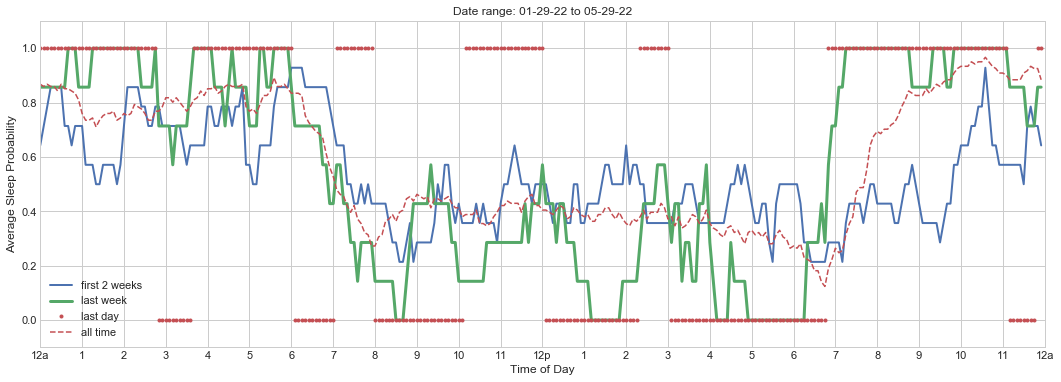

In [692]:
# Plot average daily vectors to look for patterns

fig, ax = plt.subplots(figsize=(18,6))
#plt.figure(figsize=(18,6))

plt.style.use('seaborn-whitegrid')
#ax.style.use('seaborn-whitegrid')

#plotDate=datetime.date(2022,3,14)
#dayNum=pd.Timedelta(plotDate-startDate).days

# excluding the last row of dailySleepP below as it is meant to be incomplete (only for night)

curve1, = ax.plot(dailySleepP[0:14,].mean(axis=0),'b', label='first 2 weeks', linewidth=2)

     
#biweekly=np.arange(0,numdays-14,int(numdays/14)); # Need an error catch for shorter analysis ranges
#i=biweekly[12] 
#curve3, = ax.plot(dailySleepP[i:i+14,].mean(axis=0),'g', label='last 2 weeks', linewidth=3)

#curve4, = ax.plot(dailySleepP[-15:-1,].mean(axis=0),'g--',label='last 2 weeks', linewidth=3)
curve5, = ax.plot(dailySleepP[-8:-1,].mean(axis=0),'g',label='last week', linewidth=3)

curve6, = ax.plot(dailySleepP[-2,],'r.',label='last day')

curve7, = ax.plot(dailySleepP[:-1,].mean(axis=0),'r--',label='all time')


ax.legend(handles=[curve1, curve5, curve6,curve7])

plt.xlabel('Time of Day')
plt.ylabel('Average Sleep Probability')

timeticks=np.arange(0, indexMax+1, step=int(indexMax/24));
timelabels=['12a','1','2','3','4','5','6','7','8','9','10','11','12p','1','2','3','4','5','6','7','8','9','10','11','12a']
plt.xticks(timeticks,timelabels);  # Set label locations.
plt.axis([0, indexMax,-.1,1.1]);

#plotDate=startDate+pd.Timedelta(dayNum,'d')
plt.title('Date range: '+ startDate.strftime("%m-%d-%y")+ ' to ' + endDate.strftime("%m-%d-%y"));

Fig_name= 'Oliver_SleepDailyProb_'+ startDate.strftime("%m-%d-%y")+ '_to_' + endDate.strftime("%m-%d-%y");
fig.savefig(Fig_name)

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

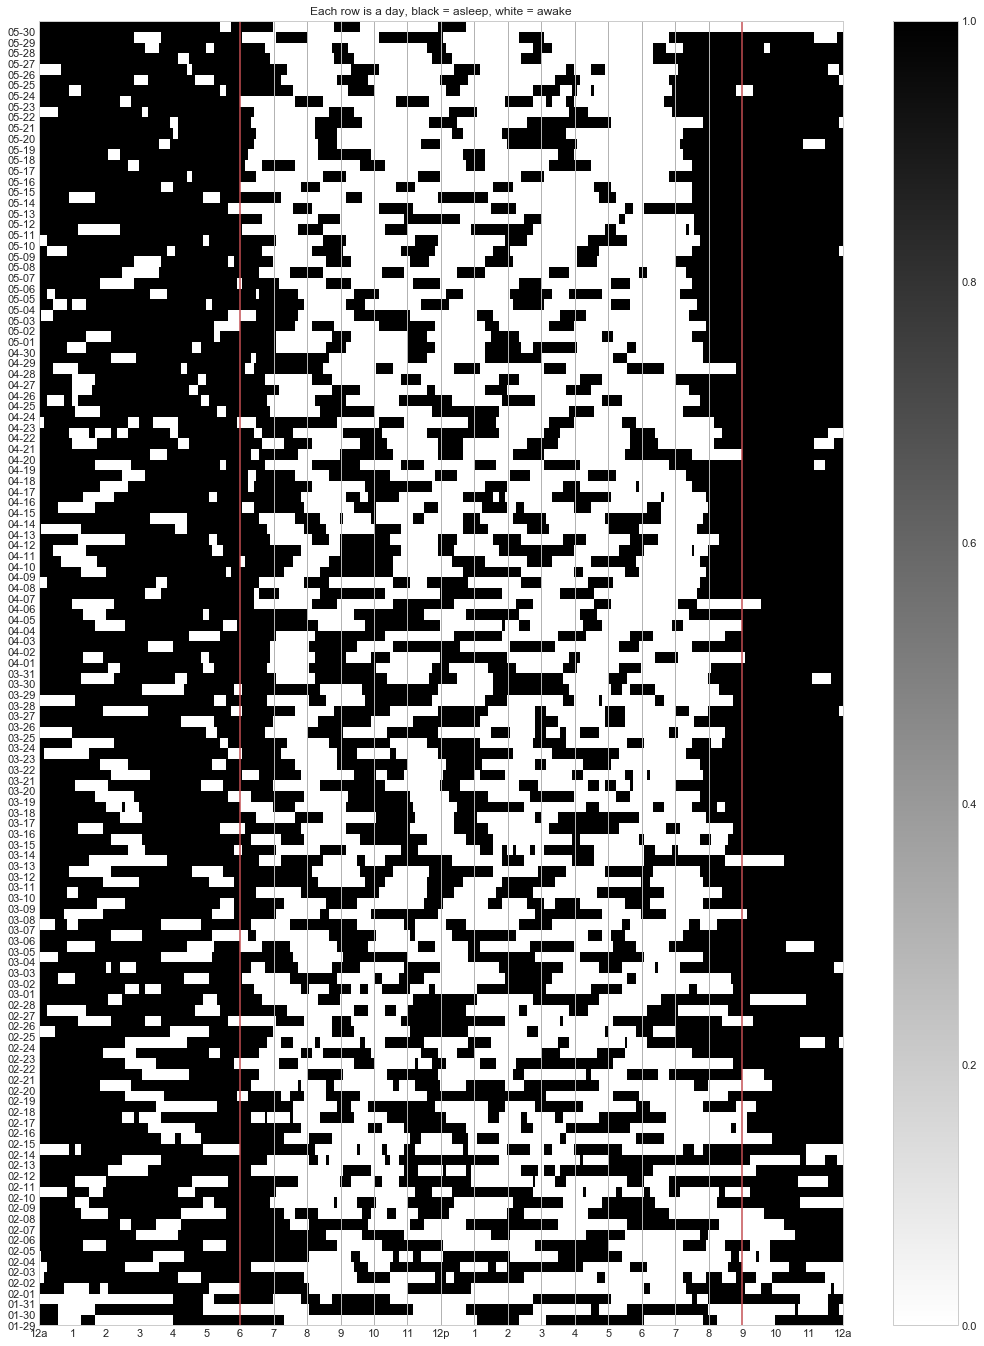

In [694]:
# Strip chart of all the daily activity vectors to look for patterns by eye

#fig, ax = plt.subplots(9,figsize=(18,35))

fig = plt.figure(figsize=(18,24))
#plt.pcolor(dailySleepP[:-1,],cmap='gray_r')
plt.pcolor(dailySleepP,cmap='gray_r')

babyAsleep=9; # pm - After this time he's generally asleep (Psleep > 80%)
babyAwake=6; # am - After this time he's generally waking (Psleep drops < 80%)

dailyDayind=int(indexMax/24*babyAwake); 
dailyNightind=int(indexMax/24*(babyAsleep+12)); 

plt.axvline(x = dailyDayind, color = 'r', label = '6 am')
plt.axvline(x = dailyNightind, color = 'r', label = '9 pm')

for h in range(0,14):
    lineind=int(indexMax/24*(7+h)); 
    plt.axvline(x = lineind, color='0.7', linewidth=1);
    
plt.xticks(timeticks,timelabels);
datelabels=pd.date_range(startDate, endDate+pd.Timedelta(1,'d')).strftime("%m-%d");
#datelabels=pd.date_range(startDate, endDate).strftime("%m-%d");
plt.yticks(np.arange(0, numdays+1),datelabels);
plt.colorbar();

plt.title('Each row is a day, black = asleep, white = awake');

Fig_name= 'Oliver_SleepMap_'+ startDate.strftime("%m-%d-%y")+ '_to_' + endDate.strftime("%m-%d-%y");
fig.savefig(Fig_name)

In [734]:
# Aggregate daily values 

SleepDaily=Sleepdata.groupby(by=Sleepdata['datetime'].dt.date).sum()/1000/60/60
Sleepbydaycounts=Sleepdata.groupby(by=Sleepdata['datetime'].dt.date).count()
SleepDaily['counts']=Sleepbydaycounts['datetime']
Sleepbydaymax=Sleepdata.groupby(by=Sleepdata['datetime'].dt.date).max()
SleepDaily['longest sleep']=Sleepbydaymax['duration']/1000/60/60 #format = '%m/%d/%Y'

skipDates1=(startDate-SleepDaily.index[0]).days
skipDates2=(SleepDaily.index[-1]-endDate).days

SleepDaily = SleepDaily.iloc[skipDates1-1:-skipDates2, :] # Remove the rows that were not of interest for analysis
#SleepDaily = SleepDaily.iloc[skipDates1-1:-skipDates2+1, :] # Remove the rows that were not of interest for analysis
SleepDaily['duration']=dailySleepP[:-1,:].sum(axis=1)*res/60

# Replaced these two count with better logic inside for loop
#SleepDaily['day naps v0']=(np.diff(dailySleepP[:-1,dailyDayind:dailyNightind])==1).sum(axis=1)-1 
#SleepDaily['night wakes v0']=(np.diff(dailySleepP[:-1,0:dailyDayind])==-1).sum(axis=1)+(np.diff(dailySleepP[:-1,dailyNightind:-1])==-1).sum(axis=1)

# Clean up the index
SleepDaily.index = pd.to_datetime(SleepDaily.index, format = '%Y/%m/%d').strftime('%m-%d')

LongestWake=[]
LongestWakeHour=[]
LongestSleepHour=[]
AverageDayNap=[]
AverageDayWake=[]
DayNapCount=[]
NightWakeCount=[] 
for i in range(0,len(SleepDaily)):  
    testS=format(dailySleepP[i,dailyDayind:-1].astype('int8')) #convert to string of integers (to use strip/split func)
    testS=testS[1:-1].replace(" ","").replace("\n","") #remove all formating in string
    
    #maxW=max(testS.strip('1').split('1')); #separate out all the wake periods (sleepP=0) and find max
    #maxS=max(testS.strip('0').split('0'))  #separate out all the sleep periods (sleepP=1) and find max
    
    wakes=testS.strip('1').split('1');
    wakes=[ele for ele in wakes if ele != ''];
    maxW=max(wakes); #separate out all the wake periods (sleepP=0) and find max
    
    LongestWake.append(len(maxW)*res/60);
    LongestWakeHour.append((testS.find(maxW)+dailyDayind)*res/60);
    
    dailyBedtimeMin=int(indexMax/24*(12+4)); 
    dailyBedtimeMax=int(indexMax/24*(12+11));
    testS=format(dailySleepP[i,dailyBedtimeMin:dailyBedtimeMax].astype('int8')) #convert to string of integers (to use strip/split func)
    testS=testS[1:-1].replace(" ","").replace("\n","") #remove all formating in string
    sleeps=testS.strip('0').split('0');
    sleeps=[ele for ele in sleeps if ele != ''];
    maxS=max(sleeps)  #separate out all the sleep periods (sleepP=1) and find max
    #if len(wakes[-1])<=6 and len(maxS)==len(sleeps[-1]):
        #print('maxS=', len(maxS))
        #print('last sleep=',len(sleeps[-1]))
     #   print(SleepDaily.index[i])
     #   print(testS.find(sleeps[-2]))
     #   if testS.find(sleeps[-2])>int(indexMax/24*17): 
     #       maxS=sleeps[-2];
            
        #print(testS.find(maxS))
    
    #LongestSleepHour.append((testS.find(maxS)+dailyDayind)*res/60);
    LongestSleepHour.append((testS.find(maxS)+dailyBedtimeMin)*res/60);
    #LongestSleepHour.append((testS.rfind(maxS)+dailyBedtimeMin)*res/60);
    
    # Bedtime logic still has some errors, 4/20 & 3/13 too early
    
    testS=format(dailySleepP[i,dailyDayind:dailyNightind].astype('int8')) #convert to string of integers (to use strip/split func)
    testS=testS[1:-1].replace(" ","").replace("\n","") #remove all formating in string
    if testS[0]=='0':
        testS=testS.lstrip('0')
    if testS[0]=='1':
        testS=testS.lstrip('1')
    if testS[-1]=='0':
        testS=testS.rstrip('0')
    if testS[-1]=='1':
        testS=testS.rstrip('1')
    dayNaps=testS.split('0');
    dayNaps = [ele for ele in dayNaps if ele != '']; # remove all the empty elements
    dayNapLengths = [len(ele) for ele in dayNaps]  
    dayWakes=testS.split('1');
    dayWakes = [ele for ele in dayWakes if ele != '']; # remove all the empty elements
    dayWakeLengths = [len(ele) for ele in dayWakes]
    dayWakeisnightWake=0;
    if dayWakeLengths[0]<=6:
        del dayWakeLengths[0]
        del dayNapLengths[0]
        dayWakeisnightWake=1;
    AverageDayNap.append(np.mean(dayNapLengths)*res/60); 
    AverageDayWake.append(np.mean(dayWakeLengths)*res/60);
    DayNapCount.append(len(dayNaps))
    testS=format(dailySleepP[i,dailyNightind:-1].astype('int8'))
    testS+=format(dailySleepP[i+1,0:dailyDayind].astype('int8'))
    testS=testS.replace(" ","").replace("\n","").replace("]","").replace("[","")  
    nightWakes=testS.split('1');
    nightWakes = [ele for ele in nightWakes if ele != ''];
    NightWakeCount.append(len(nightWakes)+dayWakeisnightWake)

SleepDaily['night wakes']=NightWakeCount;
SleepDaily['day naps']=DayNapCount;
SleepDaily['longest wake']=LongestWake;
SleepDaily['longest wake hour']=LongestWakeHour;
SleepDaily['longest sleep hour']=LongestSleepHour;
SleepDaily['average day nap']=AverageDayNap;
SleepDaily['average day wake']=AverageDayWake;

print('Avg wake window, last two weeks:',SleepDaily['average day wake'][-14:-1].mean())
print('Avg bedtime, last two weeks:',SleepDaily['longest sleep hour'][-14:-1].mean()-12)

SleepDaily.tail(10)

Avg wake window, last two weeks: 2.216452991452991
Avg bedtime, last two weeks: 7.064102564102566


,duration,counts,longest sleep,night wakes,day naps,longest wake,longest wake hour,longest sleep hour,average day nap,average day wake
05-20,14.000000,5,8.727294,1,3,3.500000,15.750000,19.250000,0.972222,2.458333
05-21,14.916667,6,4.100000,2,3,2.750000,17.083333,19.833333,1.583333,2.187500
05-22,12.916667,5,7.541035,1,3,2.833333,9.416667,18.916667,0.722222,2.583333
05-23,14.083333,7,6.298898,2,4,2.666667,16.000000,18.666667,0.562500,1.583333
05-24,13.916667,9,5.567364,3,5,2.333333,16.583333,18.916667,0.450000,1.513889
05-25,13.833333,7,5.097782,2,3,2.666667,16.166667,18.833333,0.833333,2.270833
05-26,13.416667,7,4.540472,2,4,2.583333,13.166667,19.083333,0.562500,1.883333
05-27,14.000000,5,8.855079,2,3,3.333333,15.000000,18.333333,0.583333,2.416667
05-28,12.750000,8,5.066691,2,4,3.000000,15.333333,19.250000,0.520833,2.083333
05-29,13.333333,6,5.632433,2,3,3.750000,15.083333,18.833333,1.194444,2.291667


In [636]:
#print(dailyBedtimeMin)
#print(dailyBedtimeMax)


,duration,counts,longest sleep,night wakes,day naps,longest wake,longest wake hour,longest sleep hour,average day nap,average day wake
05-23,14.083333,7,6.298898,2,4,2.666667,16.000000,18.666667,0.562500,1.583333
05-24,13.916667,9,5.567364,3,5,2.333333,16.583333,18.916667,0.450000,1.513889
05-25,13.833333,7,5.097782,2,3,2.666667,16.166667,18.833333,0.833333,2.270833
05-26,13.416667,7,4.540472,2,4,2.583333,13.166667,19.083333,0.562500,1.883333
05-27,14.000000,5,8.855079,1,3,3.333333,15.000000,18.333333,0.583333,2.416667


3-13 and 4-20 don't appear to have the right Bedtime with the current algorithm

No handles with labels found to put in legend.


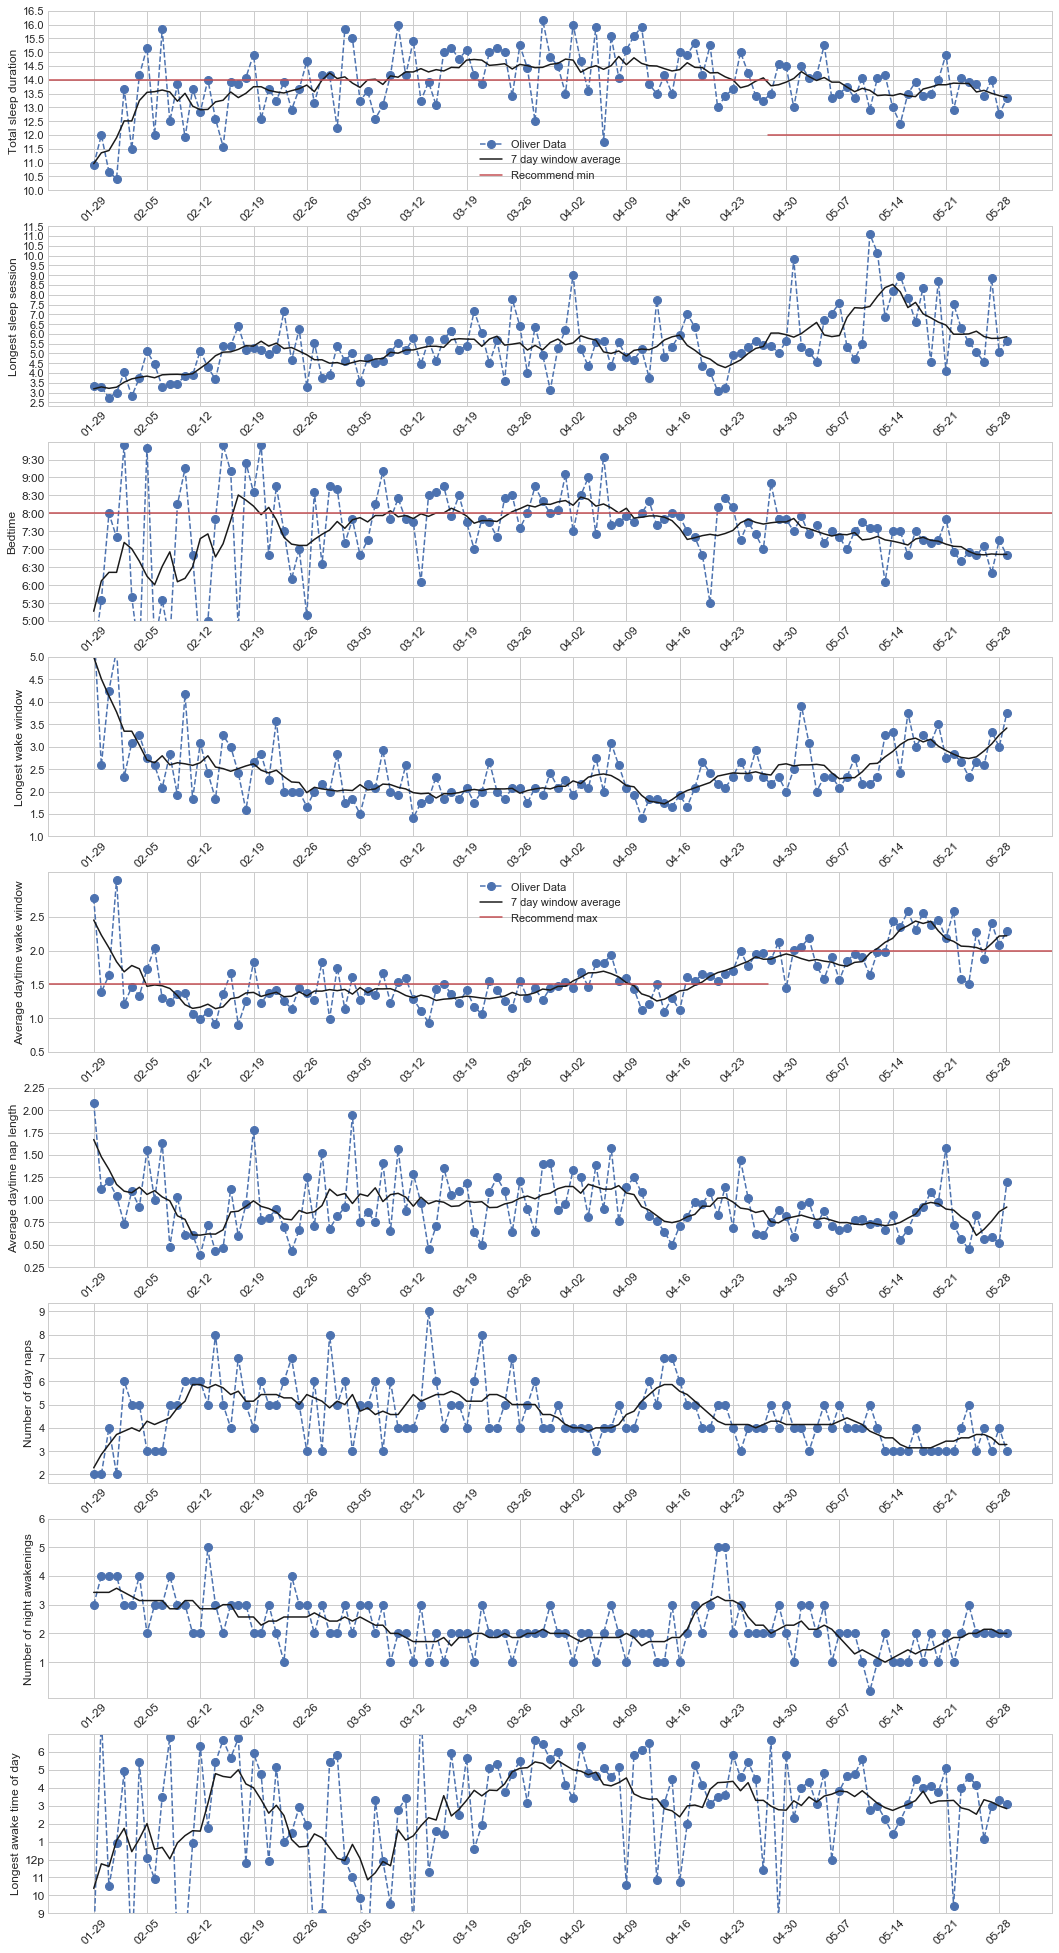

In [735]:
# Plot timeseries to look for trends  > Improvement: Turn the subplots into a function

from scipy.ndimage.filters import uniform_filter1d

fig, ax = plt.subplots(9,figsize=(18,35))

#plotStartDate=dt.date(2022,4,28);
#dayNum=pd.Timedelta(endDate-plotStartDate).days;
#SleepDaily=SleepDaily[-dayNum:]

datelabels=pd.date_range(startDate, endDate).strftime("%m-%d");
#datelabels=pd.date_range(plotStartDate, endDate).strftime("%m-%d");
datelabels=datelabels[::7]

day=np.arange(0, SleepDaily.shape[0])

SleepRunAvg=uniform_filter1d(SleepDaily['duration'], 7,mode='nearest')     

curve1a, = ax[0].plot(SleepDaily['duration'],'o--',markersize=8,label='Oliver Data');
curve1b, = ax[0].plot(day,SleepRunAvg,color='k',label='7 day window average');

index3mo=np.where(SleepDaily.index=='04-25')[0][0];
curve1c = ax[0].axhline(y=14, xmin = 0, xmax = index3mo/day[-1],color='r',label='Recommend min') #c="red",linewidth=1)
curve1d = ax[0].axhline(y=12, xmin = index3mo/day[-1], xmax = day[-1],color='r') #c="red",linewidth=1)

ax[0].set(xlabel='Date',ylabel='Total sleep duration');
ax[0].set_xticks(np.arange(0, numdays,7)); 
ax[0].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[0].set_yticks(np.arange(10, 17,.5));
ax[0].legend(loc='lower center');

SleepRunAvg=uniform_filter1d(SleepDaily['longest sleep'], 7,mode='nearest')   

curve2a, = ax[1].plot(SleepDaily['longest sleep'],'o--',markersize=8, label='Oliver Data')
curve2b, = ax[1].plot(day,SleepRunAvg,color='k',label='7 day window average')

ax[1].set(ylabel='Longest sleep session');
ax[1].set_xticks(np.arange(0, numdays,7)); 
ax[1].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[1].set_yticks(np.arange(2.5, 12,.5));
#ax[1].legend(loc='upper left');

SleepRunAvg=uniform_filter1d(SleepDaily['longest sleep hour'], 7,mode='nearest') 

curve7a, = ax[2].plot(SleepDaily['longest sleep hour'],'o--',markersize=8, label='Oliver Data')
curve7b, = ax[2].plot(day,SleepRunAvg,color='k',label='7 day window average')
curve7c = ax[2].axhline(y=20, xmin = 0, xmax = 1,color='r',label='Target') #c="red",linewidth=1)

ax[2].set(ylabel='Bedtime');
ax[2].set_xticks(np.arange(0, numdays,7)); 
ax[2].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[2].set_yticks(np.arange(17, 22,.5));
ax[2].set_ylim([17, 22])
#ax[2].set_yticklabels(['12p','1','2','3','4','5','6','7','8','9','10'], fontsize=12);
ax[2].set_yticklabels(['5:00','5:30','6:00','6:30','7:00','7:30','8:00','8:30','9:00','9:30','10:00'], fontsize=12);
ax[4].legend(loc='lower center');

SleepRunAvg=uniform_filter1d(SleepDaily['longest wake'], 7,mode='nearest') 

curve5a, = ax[3].plot(SleepDaily['longest wake'],'o--',markersize=8, label='Oliver Data')
curve5b, = ax[3].plot(day,SleepRunAvg,color='k',label='7 day window average')

ax[3].set(ylabel='Longest wake window');
ax[3].set_xticks(np.arange(0, numdays,7)); 
ax[3].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[3].set_yticks(np.arange(0, 6,.5));
ax[3].set_ylim([1, 5])
#ax[3].legend(loc='upper center');

SleepRunAvg=uniform_filter1d(SleepDaily['average day wake'], 7,mode='nearest') 

curve8a, = ax[4].plot(SleepDaily['average day wake'],'o--',markersize=8, label='Oliver Data')
curve8b, = ax[4].plot(day,SleepRunAvg,color='k',label='7 day window average')
curve8c = ax[4].axhline(y=1.5, xmin = 0, xmax = index3mo/day[-1],color='r',label='Recommend max') #c="red",linewidth=1)
curve8d = ax[4].axhline(y=2, xmin = index3mo/day[-1], xmax = day[-1],color='r') #c="red",linewidth=1)

ax[4].set(ylabel='Average daytime wake window');
ax[4].set_xticks(np.arange(0, numdays,7)); 
ax[4].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[4].set_yticks(np.arange(.5, 3,.5));
ax[4].legend(loc='upper center');

SleepRunAvg=uniform_filter1d(SleepDaily['average day nap'], 7,mode='nearest') 

curve8a, = ax[5].plot(SleepDaily['average day nap'],'o--',markersize=8, label='Oliver Data')
curve8b, = ax[5].plot(day,SleepRunAvg,color='k',label='7 day window average')
#curve8c = ax[5].axhline(y=2, xmin = 0, xmax = index3mo/day[-1],color='r',label='Recommend max') #c="red",linewidth=1)

ax[5].set(ylabel='Average daytime nap length');
ax[5].set_xticks(np.arange(0, numdays,7)); 
ax[5].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[5].set_yticks(np.arange(.25, 2.5,.25));

SleepRunAvg=uniform_filter1d(SleepDaily['day naps'].astype('float'), 7,mode='nearest') 

curve3a, = ax[6].plot(SleepDaily['day naps'],'o--',markersize=8);
curve3b, = ax[6].plot(day,SleepRunAvg,color='k',label='7 day window average')

ax[6].set(ylabel='Number of day naps');
ax[6].set_xticks(np.arange(0, numdays,7)); 
ax[6].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[6].set_yticks(np.arange(2,10));

SleepRunAvg=uniform_filter1d(SleepDaily['night wakes'].astype('float'), 7,mode='nearest') 

curve4a, = ax[7].plot(SleepDaily['night wakes'],'o--',markersize=8,label='Oliver Data');
curve4b, = ax[7].plot(day,SleepRunAvg,color='k',label='7 day window average')

ax[7].set(ylabel='Number of night awakenings');
ax[7].set_xticks(np.arange(0, numdays,7)); 
ax[7].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[7].set_yticks(np.arange(1, 7));

SleepRunAvg=uniform_filter1d(SleepDaily['longest wake hour'], 7,mode='nearest') 

curve6a, = ax[8].plot(SleepDaily['longest wake hour'],'o--',markersize=8, label='Oliver Data')
curve6b, = ax[8].plot(day,SleepRunAvg,color='k',label='7 day window average')

ax[8].set(ylabel='Longest awake time of day');
ax[8].set_xticks(np.arange(0, numdays,7)); 
ax[8].set_xticklabels(datelabels, fontsize=12,rotation = 45);
ax[8].set_yticks(np.arange(9, 19));
ax[8].set_ylim([9, 19])
ax[8].set_yticklabels(['9','10','11','12p','1','2','3','4','5','6','7'], fontsize=12);

Fig_name= 'Oliver_SleepTrends_'+ startDate.strftime("%m-%d-%y")+ '_to_' + endDate.strftime("%m-%d-%y");
fig.savefig(Fig_name)

In [ ]:
# Scratch pad for figuring out new daily calculations 

plotDate=dt.date(2022,5,11);
dayNum=pd.Timedelta(plotDate-startDate).days;

i=dayNum;

#find longest wake period
testS=format(dailySleepP[i,dailyDayind:-1].astype('int8')) #convert to string of integers (to use strip/split func)
testS=testS[1:-1].replace(" ","").replace("\n","") #remove all formating in string
wakes=testS.strip('1').split('1');
wakes=[ele for ele in wakes if ele != ''];
maxW=max(wakes); #separate out all the wake periods (sleepP=0) and find max
print('longest wake=',len(maxW)*res/60)
    
LongestWake.append(len(maxW)*res/60);
LongestWakeHour.append((testS.find(maxW)+dailyDayind)*res/60);

#find bedtime
dailyBedtimeMin=int(indexMax/24*(12+4)); 
dailyBedtimeMax=int(indexMax/24*(12+11));
testS=format(dailySleepP[i,dailyBedtimeMin:dailyBedtimeMax].astype('int8')) #convert to string of integers (to use strip/split func)
testS=testS[1:-1].replace(" ","").replace("\n","") #remove all formating in string
sleeps=testS.strip('0').split('0');
sleeps=[ele for ele in sleeps if ele != ''];
sleepLengths = [len(ele) for ele in sleeps]; #new
wakes=testS.split('1');
wakes=[ele for ele in wakes if ele != ''];
wakeLengths = [len(ele) for ele in wakes]; #new
maxS=max(sleeps)
if testS[-1]=='1':
    print('last is sleep')
else:
    print('last is not sleep')
    

#separate out all the sleep periods (sleepP=1) and find max
    #if len(wakes[-1])<=6 and len(maxS)==len(sleeps[-1]):
        #print('maxS=', len(maxS))
        #print('last sleep=',len(sleeps[-1]))
     #   print(SleepDaily.index[i])
     #   print(testS.find(sleeps[-2]))
     #   if testS.find(sleeps[-2])>int(indexMax/24*17): 
     #       maxS=sleeps[-2];
            
        #print(testS.find(maxS))
    
    #LongestSleepHour.append((testS.find(maxS)+dailyDayind)*res/60);
LongestSleepHour.append((testS.find(maxS)+dailyBedtimeMin)*res/60);
    
    # Bedtime logic still has some errors, 4/20 & 3/13 too early, 5/24 was fixed by moving night end to 11pm
    
#find day naps and wake windows    
testS=format(dailySleepP[i,dailyDayind:dailyNightind].astype('int8')) #convert to string of integers (to use strip/split func)
testS=testS[1:-1].replace(" ","").replace("\n","") #remove all formating in string
if testS[0]=='0':
    testS=testS.lstrip('0')
if testS[0]=='1':
    testS=testS.lstrip('1')
if testS[-1]=='0':
    testS=testS.rstrip('0')
if testS[-1]=='1':
    testS=testS.rstrip('1')
dayNaps=testS.split('0');
dayNaps = [ele for ele in dayNaps if ele != '']; # remove all the empty elements
dayNapLengths = [len(ele) for ele in dayNaps]  
dayWakes=testS.split('1');
dayWakes = [ele for ele in dayWakes if ele != '']; # remove all the empty elements
maxW2=max(dayWakes);

print('longest wake2=',len(maxW2)*res/60)

dayWakeLengths = [len(ele) for ele in dayWakes]
dayWakeisnightWake=0;
if dayWakeLengths[0]<=6:
    del dayWakeLengths[0]
    del dayNapLengths[0]
    dayWakeisnightWake=1;
#AverageDayNap.append(np.mean(dayNapLengths)*res/60); 
#AverageDayWake.append(np.mean(dayWakeLengths)*res/60);
#DayNapCount.append(len(dayNaps))

    
#LongestWake.append(len(maxW)*res/60);
#LongestWakeHour.append((testS.find(maxW)+dailyDayind)*res/60);



#find night wake periods
testS=format(dailySleepP[i,dailyNightind:-1].astype('int8'))
testS+=format(dailySleepP[i+1,0:dailyDayind].astype('int8'))
testS=testS.replace(" ","").replace("\n","").replace("]","").replace("[","")  
nightWakes=testS.split('1');
nightWakes = [ele for ele in nightWakes if ele != ''];
#NightWakeCount.append(len(nightWakes)+dayWakeisnightWake)

print('sleep lengths:',sleepLengths)
print('wake lengths:',wakeLengths)
print('day wake lengths:',dayWakeLengths)
print('day nap lengths:',dayNapLengths)

5/13 - could be earlier bedtime

In [ ]:
wakes

In [738]:
testS.find(maxS)

15

In [739]:
sleeps

['1111111', '11111111111111111111111111111', '111111111']

In [545]:
SleepDaily['test']=SleepDaily['night wakes']-SleepDaily['night wakes v0'];
SleepDaily[['night wakes','night wakes v0','test']][SleepDaily['test']!=0]

KeyError: 'night wakes v0'

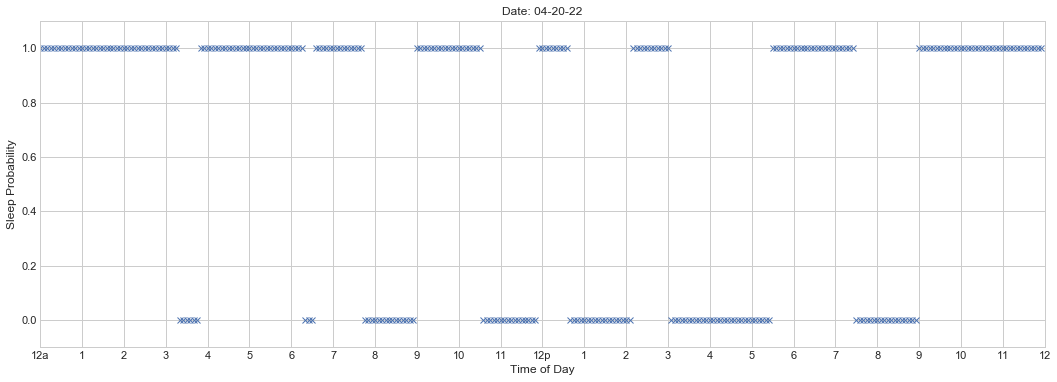

In [590]:
# This can used to visualize each individual vector by date (optional)

plt.figure(figsize=(18,6))
plt.style.use('seaborn-whitegrid')

plotDate=dt.date(2022,4,20)
dayNum=pd.Timedelta(plotDate-startDate).days

#plt.plot(dayvec)
plt.plot(dailySleepP[dayNum,],'x')
plt.xlabel('Time of Day')
plt.ylabel('Sleep Probability')

timeticks=np.arange(0, indexMax+1, step=int(indexMax/24));
timelabels=['12a','1','2','3','4','5','6','7','8','9','10','11','12p','1','2','3','4','5','6','7','8','9','10','11','12']
plt.xticks(timeticks,timelabels);  # Set label locations.
plt.axis([0, indexMax,-.1,1.1]);

#plotDate=startDate+pd.Timedelta(dayNum,'d')
plt.title('Date: '+ plotDate.strftime("%m-%d-%y"));

In [454]:
SleepDaily['test']=SleepDaily['day naps']-SleepDaily['day naps v0'];
SleepDaily[['day naps','day naps v0','test']][SleepDaily['test']!=0]

,day naps,day naps v0,test
01-30,2,3,-1
02-19,4,5,-1
02-22,5,6,-1
02-26,3,4,-1
03-05,5,6,-1
03-06,5,6,-1
03-14,9,10,-1
03-16,4,5,-1
03-18,5,6,-1
03-19,4,5,-1


In [659]:
#%magic

dtype('float64')

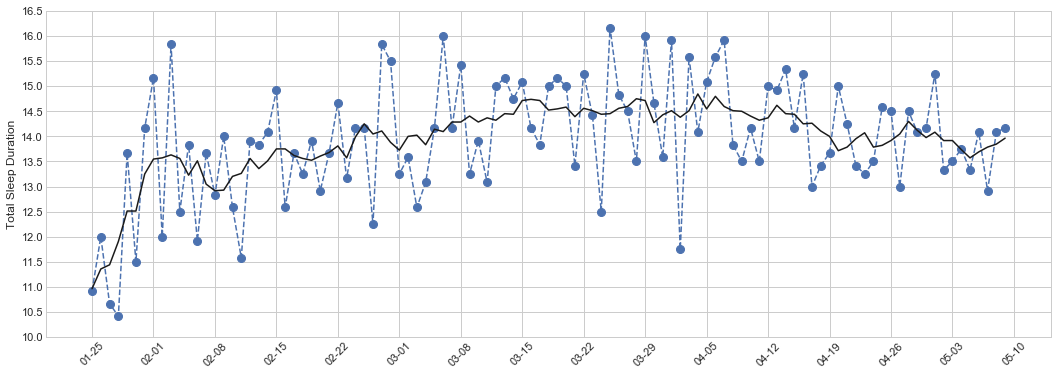

In [675]:
plt.figure(figsize=(18,6))


   
SleepDurationRunAvg=uniform_filter1d(SleepDaily['duration'], 7,mode='nearest')     

startDate=dt.date(2022,1,25)
numdays=pd.Timedelta(endDate-startDate).days+1

datelabels=pd.date_range(startDate, endDate).strftime("%m-%d");
datelabels=datelabels[::7]

plt.xticks(np.arange(0, numdays,7),datelabels);

plt.plot(SleepDaily.index,SleepDaily['duration'],'o--',markersize=8);
plt.plot(day,SleepDurationRunAvg,color='k')



plt.ylabel('Total Sleep Duration')
plt.xticks(rotation = 45);
plt.yticks(np.arange(10, 17,.5));

In [677]:
print(len(day))
print(numdays/7)
print(len(np.arange(0, numdays,7)))
print(len(SleepDaily['duration']))

105
15.571428571428571
16
105


In [676]:
SleepDaily.index

Index(['01-29', '01-30', '01-31', '02-01', '02-02', '02-03', '02-04', '02-05',
       '02-06', '02-07',
       ...
       '05-04', '05-05', '05-06', '05-07', '05-08', '05-09', '05-10', '05-11',
       '05-12', '05-13'],
      dtype='object', length=105)

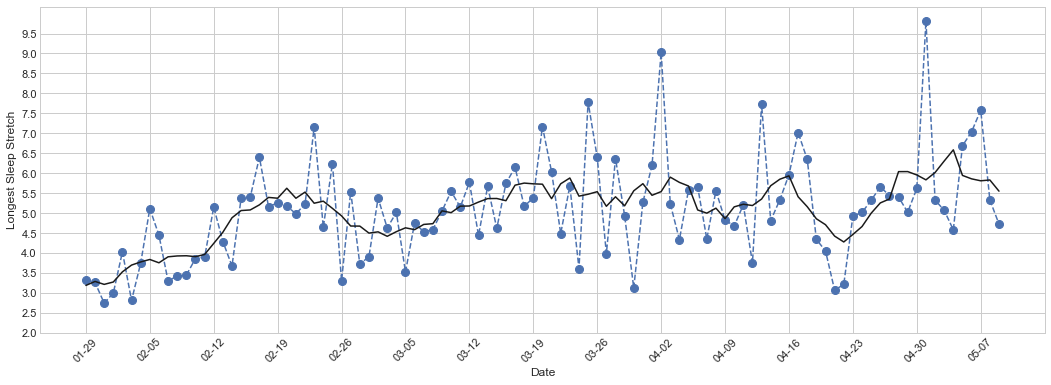

In [422]:
# Plotting scratch pad



#plt.yticks(np.arange(0, numdays+1),datelabels);

#datelabels2=pd.date_range(startDate, endDate+pd.Timedelta(1,'d'),(numdays)/7).strftime("%m-%d");

#datelabels.shape

#datelabels=pd.date_range(startDate, endDate+pd.Timedelta(1,'d')).strftime("%m-%d");
#plt.yticks(np.arange(0, numdays+1),datelabels);

#plt.bar(Sleepbyday['datetime'],Sleepbyday['duration'])
#day=np.linspace(1, 10, num=10)

day=np.arange(0, SleepDaily.shape[0])

#SleepDurationRunAvg=np.convolve(Sleepbyday['duration'], np.ones(7)/7, mode='valid');
    
from scipy.ndimage.filters import uniform_filter1d

#SleepDurationRunAvg=uniform_filter1d(SleepDaily['duration'], 7,mode='nearest')    
SleepDurationRunAvg=uniform_filter1d(SleepDaily['longest'], 7,mode='nearest')     
    
#1 to Sleepbyday['datetime'].shape
plt.figure(figsize=(18,6))
#plt.bar(day,SleepDaily['duration'])

#plt.bar(day,SleepDaily['longest'])
#plt.bar(SleepDaily['datetime'],SleepDaily['longest'])
plt.plot(SleepDaily['longest'],'o--',markersize=8)

#hourly_ticks = 4 * 60 * 60 * np.arange(6)
#by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

plt.plot(day,SleepDurationRunAvg,color='k')

# Label the axes
#plt.xlabel('Day Number')
plt.xlabel('Date')

#datelabels=pd.date_range(startDate, endDate,(numdays)/7).strftime("%m-%d");
plt.xticks(np.arange(0, numdays,7),datelabels);

#plt.ylabel('Total Sleep Duration')
plt.ylabel('Longest Sleep Stretch')
plt.xticks(rotation = 45)
plt.yticks(np.arange(2, 10,.5));
#plt.axis([0, 90,10,16])
#plt.ylim((0,10))


#datelabels=pd.date_range(startDate, endDate).strftime("%m-%d");


#label the figure
#plt.title(hist_country)

# to make more honest, start they y axis at 0
#plt.axis([1959, 2011,0,25])

#plt.axis([0, Sleepbyday.shape[0]+1-7,10,16])
#plt.axis([0, 90,10,16])
#plt.yaxis([0, 10])
#plt.ylim((0,10))

#plt.grid(color='r', axis='y',linestyle='--', linewidth=1)
mpl.rcParams.update({'font.size': 32})
plt.show()

In [23]:
# Scratch pad on datetime conversions

dob=dt.datetime(2022,1,25,20,22)
dob_millis=int(dt.datetime.timestamp(dob)*1000)

# Something like the below (didn't work)
# sql_query4="REPLACE INTO babies (birthday) VALUES dob_millis"
# cursor.execute(sql_query4)

#Babydata['datetime']=pd.to_datetime(Babydata['start_millis'],unit='ms')
#Babydata['datetime']=pd.to_datetime(Babydata['start_millis'],unit='ms',utc=True) #This is in UTC time 
#Babydata['datetime']=pd.Timestamp(Babydata['start_millis'],unit='ms', tz='US/Pacific')

#from dateutil import tz
#dst = tz.gettz('America/Creston')
#print(dst)

#Babydata['datetime']=pd.datetime(Babydata['start_millis'],unit='ms',tzinfo=dst,utc=True); 
#Babydata['datetime']=Babydata['datetime'].dt.to_pydatetime();#Babydata['start_millis'],unit='ms',tzinfo=dst,utc=True);

#range(Babydata.shape[0])
#for i in range(Babydata.shape[0]):
#    Babydata['datetime_tz'][i]=Babydata['datetime'][i].replace(tzinfo=dst);#.replace(tzinfo=dst)


        #date=Sleepdata['datetime_tz'][i].date();
        #date=Sleepdata['datetime'][i].replace(tzinfo=dst).date();
        #date=Sleepdata['datetime'][i].dt.tz_localize
        #daytime=Sleepdata['datetime_tz'][i]-dt.datetime.combine(date, dt.timetz(0,0,));
        #daytime=Sleepdata['datetime'][i].replace(tzinfo=dst)-dt.datetime.combine(date, dt.time(0,0)).replace(tzinfo=dst);
        #daytime=Sleepdata['datetime'][i].dt.tz_localize-dt.datetime.combine(date, dt.time(0,0));
        
#Babydata['datetime_tz']=Babydata['datetime'];

#for items in Babydata['datetime'].iteritems():
    #print(items)
    #print(type(items))
    
#Babydata['datetime'][0]=Babydata['datetime'][0].replace(tzinfo=dst)

#Babydata['datetime'][0].dt.tz_localize

In [157]:
import numpy as np

In [163]:
np.power(10,40*np.log10(300/250))*203/40

7459.090707443109

In [162]:
10^2

8

In [156]:
import numpy as np
np.log10(100)

NameError: name 'log10' is not defined

In [249]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.randint(0, 10, 4))
print(ser)

0    6
1    3
2    7
3    4
dtype: int64


In [250]:
np.exp(ser)

0     403.428793
1      20.085537
2    1096.633158
3      54.598150
dtype: float64

In [254]:
np.exp(1)

2.718281828459045

In [253]:
np.exp?

In [ ]:
# This did not work, wanted to make a horizontally scrollable plot for the figure below

from matplotlib.widgets import Slider 
#fig, ax = plt.subplots()
#plt.subplots_adjust(bottom=0.25)

#slider_color='White'
#ax_pos = plt.axes([0.2, 0.1, 0.65, 0.03],facecolor=slider_color)
#slider_pos = Slider(ax_pos, 'Pos', 0.1, 90.0)

#def update(val):
#    pos = slider_pos.val
#    ax.axis([pos,pos+10,-1,1])
#    fig.canvas.draw_idle()

#slider_pos.on_changed(update)

#plt.show()

In [ ]:
# Wanted to select a date range of intereste for all the plots above

#datelabels=pd.date_range(startDate, endDate).strftime("%y-%m-%d");
#datelabels=datelabels[::30] # 7 pick every N only (to avoid overcrowding) 

#day=np.arange(0, SleepDaily.shape[0])

#plotStartDate=dt.date(2022,4,28);
#dayNum=pd.Timedelta(endDate-plotStartDate).days;
#SleepDaily=SleepDaily[-dayNum:]

#datelabels=pd.date_range(startDate, endDate).strftime("%y-%m-%d");
#datelabels=pd.date_range(plotStartDate, endDate).strftime("%m-%d");
#datelabels=datelabels[::30]

#day=np.arange(0, SleepDaily.shape[0])  

# Need to find a generalized way to include the recommendations
#index3mo=np.where(SleepDaily.index=='2022-04-25')[0][0];
#curve1c = ax[0].axhline(y=14, xmin = 0, xmax = index3mo/day[-1],color='r',label='Recommend min') #c="red",linewidth=1)
#curve1d = ax[0].axhline(y=12, xmin = index3mo/day[-1], xmax = day[-1],color='r') #c="red",linewidth=1)

#fig.set(xlabel='Date',ylabel='Sleep total');
#plt.xticks(np.arange(0, numDays,7))
#ax[0].set_xticklabels(datelabels, fontsize=12,rotation = 45);
#plt.yticks(np.arange(9, 17,.5));